# Introduction

The solution that follows has been developed to address the challenge on data visualization present at this [link](https://github.com/localytics/data-viz-challenge). Here the goal is to determine which user segments would be for bicycle made up of recycled parts available on the BootLoader app. The main goal here is to clean up the received data and visualize multiple characteristics of it

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/localytics/data.json


In [2]:
!pip install datasets

# Datasets Loading and cleanup

1. The load_dataset class of the datasets function can be used to read the input data which is shared as a json file

In [3]:
from datasets import load_dataset
raw_data_struct = {'train':'/kaggle/input/localytics/data.json'}
raw_dataset = load_dataset('json',data_files=raw_data_struct,field='data')
raw_dataset

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-f752a2f97ad9a12d/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['category', 'event_name', 'gender', 'age', 'marital_status', 'session_id', 'device', 'client_time', 'location'],
        num_rows: 50000
    })
})

In [4]:
raw_dataset['train'][:2]

{'category': ['Sports', 'Technology'],
 'event_name': ['View Project', 'View Project'],
 'gender': ['M', 'M'],
 'age': ['18-24', '18-24'],
 'marital_status': ['married', 'single'],
 'session_id': ['69f62d2ae87640f5a2dde2b2e9229fe6',
  '4459d001feb8438eae5f4ec24abcd992'],
 'device': ['android', 'iOS'],
 'client_time': [1393632004, 1393632022],
 'location': [{'city': 'Lyons',
   'latitude': 40.189788,
   'longitude': -105.35528,
   'state': 'CO',
   'zip_code': '80540'},
  {'city': 'Alpharetta',
   'latitude': 33.844371,
   'longitude': -84.47405,
   'state': 'GA',
   'zip_code': '30009'}]}

2. **Clean-up step 1:** On diplaying the first 2 dataset elements we find that the location feature has nested features within it. Let's create a function to expose the nested fields and subject the dataset to this function. The location column can be removed in the process as it would no longer be required

In [5]:
def expose_internal_features(item):
    return {
        'city':[el['city'] for el in item['location']],
        'latitude':[el['latitude'] for el in item['location']],
        'longitude':[el['longitude'] for el in item['location']],
        'state':[el['state'] for el in item['location']],
        'zip_code':[el['zip_code'] for el in item['location']]
    }

unwrapped_raw_dataset =  raw_dataset.map(expose_internal_features,batched=True,remove_columns=['location'])
unwrapped_raw_dataset

  0%|          | 0/50 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['category', 'event_name', 'gender', 'age', 'marital_status', 'session_id', 'device', 'client_time', 'city', 'latitude', 'longitude', 'state', 'zip_code'],
        num_rows: 50000
    })
})

In [6]:
unwrapped_raw_dataset['train'][:2]

{'category': ['Sports', 'Technology'],
 'event_name': ['View Project', 'View Project'],
 'gender': ['M', 'M'],
 'age': ['18-24', '18-24'],
 'marital_status': ['married', 'single'],
 'session_id': ['69f62d2ae87640f5a2dde2b2e9229fe6',
  '4459d001feb8438eae5f4ec24abcd992'],
 'device': ['android', 'iOS'],
 'client_time': [1393632004, 1393632022],
 'city': ['Lyons', 'Alpharetta'],
 'latitude': [40.189788, 33.844371],
 'longitude': [-105.35528, -84.47405],
 'state': ['CO', 'GA'],
 'zip_code': ['80540', '30009']}

As an extension of the existing cleanup step, let's translate the datasetdict type into a pandas data frame and fix any missing data gaps or outliers

In [7]:
unwrapped_raw_dataset['train'].set_format('pandas')
feature_names = unwrapped_raw_dataset['train'].column_names
fulldata_df = unwrapped_raw_dataset['train'][:]
fulldata_df.head()

,category,event_name,gender,age,marital_status,session_id,device,client_time,city,latitude,longitude,state,zip_code
0,Sports,View Project,M,18-24,married,69f62d2ae87640f5a2dde2b2e9229fe6,android,1393632004,Lyons,40.189788,-105.355280,CO,80540
1,Technology,View Project,M,18-24,single,4459d001feb8438eae5f4ec24abcd992,iOS,1393632022,Alpharetta,33.844371,-84.474050,GA,30009
2,Environment,View Project,M,55+,single,0db9ed700a184d48a9d04806696e3642,iOS,1393632032,Westford,42.446396,-71.459405,MA,01886
3,Technology,View Project,M,18-24,single,68195e2372bd4022b17220fc21de9138,android,1393632038,Saranac,44.624413,-73.809266,NY,12981
4,Sports,View Project,F,25-34,married,9508a8385dc94773baba8aa7d1c2aa75,iOS,1393632051,Lampe,36.747083,-93.458626,MO,65681


**Clean-up step 2:** Let's check for missing elemtents and also inspect the number of unique values corresponding to each feature

In [8]:
fulldata_df.isna().sum()

category          0
event_name        0
gender            0
age               0
marital_status    0
session_id        0
device            0
client_time       0
city              0
latitude          0
longitude         0
state             0
zip_code          0
dtype: int64

Looks like the dataset is clean in terms of missing values

In [9]:
fulldata_df.nunique()

category              5
event_name            2
gender                3
age                   5
marital_status        2
session_id        10466
device                2
client_time       49467
city               2887
latitude           4601
longitude          4601
state                51
zip_code           4959
dtype: int64

In [10]:
fulldata_df.shape

(50000, 13)

Thus, it is likely that a user has done multiple site visits with each visit differing based on the product category involved or the event. Let's validate this quickly

In [11]:
#Check how many entries are available in the dataset corresponding to each user
fulldata_df['session_id'].value_counts().to_frame().reset_index()

,index,session_id
0,f396a9f77e3a4113b6f228f64d3afd48,27
1,848b1d85385440b49cf07ead528c35b0,24
2,8d1aaa665f204d7a8b48a500c0f44018,23
3,031b5195a3ba400eabe58b05bda1173c,23
4,be389e9be0e74398adcef3292ac409ee,23
...,...,...
10461,4a34f8687cfc4e75a39806a0dfddd9bd,1
10462,67a714aa29024b28ae82470fc0a11884,1
10463,eecac00b30964a5989a90c0933820a22,1
10464,0264543280314882b3d9125500c0aaa8,1


In [12]:
#Let's check the unique values for each feature corresponding to a sample user
sample = fulldata_df[fulldata_df.session_id == fulldata_df['session_id'].value_counts().to_frame().reset_index().loc[0,'index']]
sample

,category,event_name,gender,age,marital_status,session_id,device,client_time,city,latitude,longitude,state,zip_code
610,Fashion,View Project,F,45-54,married,f396a9f77e3a4113b6f228f64d3afd48,iOS,1393642129,Perrysville,40.023673,-87.475513,IN,47974
2804,Fashion,Fund Project,F,45-54,married,f396a9f77e3a4113b6f228f64d3afd48,iOS,1393691028,Perrysville,40.023673,-87.475513,IN,47974
6579,Fashion,View Project,F,45-54,married,f396a9f77e3a4113b6f228f64d3afd48,iOS,1393793395,Perrysville,40.023673,-87.475513,IN,47974
6970,Technology,View Project,F,45-54,married,f396a9f77e3a4113b6f228f64d3afd48,iOS,1393805727,Perrysville,40.023673,-87.475513,IN,47974
8947,Technology,View Project,F,45-54,married,f396a9f77e3a4113b6f228f64d3afd48,iOS,1393869024,Perrysville,40.023673,-87.475513,IN,47974
9383,Fashion,Fund Project,F,45-54,married,f396a9f77e3a4113b6f228f64d3afd48,iOS,1393883499,Perrysville,40.023673,-87.475513,IN,47974
9650,Fashion,View Project,F,45-54,married,f396a9f77e3a4113b6f228f64d3afd48,iOS,1393892144,Perrysville,40.023673,-87.475513,IN,47974
9932,Technology,View Project,F,45-54,married,f396a9f77e3a4113b6f228f64d3afd48,iOS,1393902470,Perrysville,40.023673,-87.475513,IN,47974
11818,Technology,View Project,F,45-54,married,f396a9f77e3a4113b6f228f64d3afd48,iOS,1393970657,Perrysville,40.023673,-87.475513,IN,47974
13000,Technology,Fund Project,F,45-54,married,f396a9f77e3a4113b6f228f64d3afd48,iOS,1394012956,Perrysville,40.023673,-87.475513,IN,47974


One immediate issue that jumps out is the gender feature taking on the 'unknown' value for a user in some site visits even when the gender is known in other site visits. Let's inspect the entire dataset for such errors which will correspond to the third clean-up step

**Clean-up step 3:** Function to identify number of unique values for each feature corresponding to each unique visitor/user and fix those instances where conflicting feature values occur for a particular user

In [13]:
def create_unique_element_count_grid(df):
    user_unq_feature_count=[]
    for i,id in enumerate(df['session_id'].unique()):
        unique_count = df[df.session_id == id].nunique().to_frame().rename(columns={0:id})
        user_unq_feature_count.append(unique_count)
    unique_counter_df = pd.concat(user_unq_feature_count,axis='columns')
    unique_counter_df.drop(['category','event_name'],inplace=True)
    return unique_counter_df.transpose()

In [14]:
unique_cnt_grid = create_unique_element_count_grid(fulldata_df)
unique_cnt_grid

,gender,age,marital_status,session_id,device,client_time,city,latitude,longitude,state,zip_code
69f62d2ae87640f5a2dde2b2e9229fe6,1,1,1,1,1,12,1,1,1,1,1
4459d001feb8438eae5f4ec24abcd992,2,1,1,1,1,15,1,1,1,1,1
0db9ed700a184d48a9d04806696e3642,1,1,1,1,1,3,1,1,1,1,1
68195e2372bd4022b17220fc21de9138,1,1,1,1,1,17,1,1,1,1,1
9508a8385dc94773baba8aa7d1c2aa75,2,1,1,1,1,7,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
408dd79552984df9a23c1c269848a2f8,1,1,1,1,1,1,1,1,1,1,1
76c66ae7b40648da852809abf7bc4b43,1,1,1,1,1,1,1,1,1,1,1
3811d92fc7aa4892a4eb72743a103ace,1,1,1,1,1,1,1,1,1,1,1
0913f28e777a4fbfba6c7112371a061c,1,1,1,1,1,1,1,1,1,1,1


In [15]:
unique_cnt_grid.drop(['session_id','client_time'],axis='columns',inplace=True)
unique_cnt_grid.nunique()

gender            2
age               1
marital_status    1
device            1
city              1
latitude          1
longitude         1
state             1
zip_code          1
dtype: int64

Hence, gender is the only feature that requires error correction. Let's make sure that the gender does not show as 'M' across some sessions and 'F' across other sessions for a given user. Let's then ensure that each user corresponds to just one gender feature value

In [16]:
gender_data = fulldata_df[['session_id','gender']]
gender_data.drop_duplicates(inplace=True)
gender_data

/tmp/ipykernel_32/2928461138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gender_data.drop_duplicates(inplace=True)


,session_id,gender
0,69f62d2ae87640f5a2dde2b2e9229fe6,M
1,4459d001feb8438eae5f4ec24abcd992,M
2,0db9ed700a184d48a9d04806696e3642,M
3,68195e2372bd4022b17220fc21de9138,M
4,9508a8385dc94773baba8aa7d1c2aa75,F
...,...,...
49962,408dd79552984df9a23c1c269848a2f8,M
49973,76c66ae7b40648da852809abf7bc4b43,M
49975,3811d92fc7aa4892a4eb72743a103ace,F
49976,0913f28e777a4fbfba6c7112371a061c,M


In [17]:
gender_dist = pd.crosstab(gender_data['session_id'],gender_data['gender']).reset_index()
gender_dist

gender,session_id,F,M,U
0,000716c0e76a41508feb786d202748e7,0,1,1
1,000e13dfa71146e192060542cda8721d,1,0,1
2,0018be2c216249469b0f04f51ca9bc0a,0,1,0
3,002a9c51650d47f281518d91717c8d31,1,0,1
4,0030f720272e45b28b13a1b06044adc2,1,0,0
...,...,...,...,...
10461,ffdff9e658e245a1b13540b04ca13f5a,0,1,1
10462,ffe022e5e4064754814311d418d65e59,1,0,0
10463,fff2dc58df814daf8cd28cc28a67dbae,0,1,0
10464,fff64032b12c437ba4bf81d96a5a7d76,0,1,0


In [18]:
def clean_gender(x):
    if x['F']==1 and x['M']==1:
        return 'error'
    elif x['F']==1:
        return 'F'
    else:
        return 'M'

gender_dist['gender_cleaned'] = gender_dist.apply(clean_gender,axis='columns')
gender_dist['gender_cleaned'].value_counts()

M    5260
F    5206
Name: gender_cleaned, dtype: int64

Hence, now all the unknown gender values have been either changed to M or F. Let's merge the cleaned gender column with the rest of the array

In [19]:
fulldata_cleaned = fulldata_df.merge(gender_dist[['session_id','gender_cleaned']],how='left',on='session_id')
fulldata_cleaned.head()

,category,event_name,gender,age,marital_status,session_id,device,client_time,city,latitude,longitude,state,zip_code,gender_cleaned
0,Sports,View Project,M,18-24,married,69f62d2ae87640f5a2dde2b2e9229fe6,android,1393632004,Lyons,40.189788,-105.355280,CO,80540,M
1,Technology,View Project,M,18-24,single,4459d001feb8438eae5f4ec24abcd992,iOS,1393632022,Alpharetta,33.844371,-84.474050,GA,30009,M
2,Environment,View Project,M,55+,single,0db9ed700a184d48a9d04806696e3642,iOS,1393632032,Westford,42.446396,-71.459405,MA,01886,M
3,Technology,View Project,M,18-24,single,68195e2372bd4022b17220fc21de9138,android,1393632038,Saranac,44.624413,-73.809266,NY,12981,M
4,Sports,View Project,F,25-34,married,9508a8385dc94773baba8aa7d1c2aa75,iOS,1393632051,Lampe,36.747083,-93.458626,MO,65681,F


In [20]:
fulldata_cleaned['gender_cleaned'].value_counts()
fulldata_cleaned.drop(['gender'],axis='columns',inplace=True)

**Clean-up step 4:** The dataset can be reorganized to ensure that the relationship between a user and a category corresponds to just a single entry in the input data frame. For this:
1. The category and event_name column values can be pivoted into columns for indicating number of views and count of fundings offered by a particular user to a particular product category 
2. There can be an additional feature on average duration between successive visits

1. Generate cross-tabs of user and category combination with even_name values so that number of views and number of times a particular category was funded are obtained

In [21]:
user_action_data = fulldata_cleaned[['session_id','category','event_name']]

In [22]:
fund_view_actions = pd.crosstab([user_action_data['session_id'],user_action_data['category']],user_action_data['event_name']).reset_index()
fund_view_actions['Fund Project'].value_counts()

1    12905
0     6014
2     2833
3      548
4       95
5        9
6        3
Name: Fund Project, dtype: int64

In [23]:
fund_view_actions.duplicated(keep=False).value_counts()

False    22407
dtype: int64

Thus every combination of user and product category has a unique entry for capturing the categories views and the fundings offered
Let's create a new feature which captures the average number of views required per funding offer

In [24]:
fund_view_actions.columns

Index(['session_id', 'category', 'Fund Project', 'View Project'], dtype='object', name='event_name')

In [25]:
def create_views_per_fund(x):
    if x['Fund Project']==0:
        return 0.0
    else:
        return float(x['View Project'])/x['Fund Project']
    
fund_view_actions['Views_per_funding'] = fund_view_actions.apply(create_views_per_fund,axis=1)
fund_view_actions.head()

event_name,session_id,category,Fund Project,View Project,Views_per_funding
0,000716c0e76a41508feb786d202748e7,Environment,1,2,2.0
1,000716c0e76a41508feb786d202748e7,Sports,0,1,0.0
2,000e13dfa71146e192060542cda8721d,Fashion,1,1,1.0
3,000e13dfa71146e192060542cda8721d,Games,1,1,1.0
4,000e13dfa71146e192060542cda8721d,Sports,1,1,1.0


2. Let's create a variable which captures the average duration between successive actions for particular user on a particular category

In [26]:
user_category_timestamp = fulldata_cleaned[['session_id','category','client_time']].sort_values(['session_id','category','client_time'],ascending=[True,True,True])
user_category_timestamp.head(20)

,session_id,category,client_time
15244,000716c0e76a41508feb786d202748e7,Environment,1394102342
21233,000716c0e76a41508feb786d202748e7,Environment,1394363718
47024,000716c0e76a41508feb786d202748e7,Environment,1396055613
16182,000716c0e76a41508feb786d202748e7,Sports,1394141899
8703,000e13dfa71146e192060542cda8721d,Fashion,1393861797
29722,000e13dfa71146e192060542cda8721d,Fashion,1394820011
16747,000e13dfa71146e192060542cda8721d,Games,1394165436
25003,000e13dfa71146e192060542cda8721d,Games,1394553105
10233,000e13dfa71146e192060542cda8721d,Sports,1393913664
14321,000e13dfa71146e192060542cda8721d,Sports,1394065159


In [27]:
user_category_timestamp['interval_between_actions'] = user_category_timestamp['client_time'].diff()
mask = ((user_category_timestamp.session_id != user_category_timestamp.session_id.shift(1)) | (user_category_timestamp.category != user_category_timestamp.category.shift(1)))
user_category_timestamp['interval_between_actions'][mask] = np.nan
user_category_timestamp.head(20)

/tmp/ipykernel_32/2338085359.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_category_timestamp['interval_between_actions'][mask] = np.nan


,session_id,category,client_time,interval_between_actions
15244,000716c0e76a41508feb786d202748e7,Environment,1394102342,NaN
21233,000716c0e76a41508feb786d202748e7,Environment,1394363718,261376.0
47024,000716c0e76a41508feb786d202748e7,Environment,1396055613,1691895.0
16182,000716c0e76a41508feb786d202748e7,Sports,1394141899,NaN
8703,000e13dfa71146e192060542cda8721d,Fashion,1393861797,NaN
29722,000e13dfa71146e192060542cda8721d,Fashion,1394820011,958214.0
16747,000e13dfa71146e192060542cda8721d,Games,1394165436,NaN
25003,000e13dfa71146e192060542cda8721d,Games,1394553105,387669.0
10233,000e13dfa71146e192060542cda8721d,Sports,1393913664,NaN
14321,000e13dfa71146e192060542cda8721d,Sports,1394065159,151495.0


In [28]:
user_category_timestamp.drop(['client_time'],inplace=True,axis='columns')
avg_interval_actions = user_category_timestamp.groupby(['session_id','category']).mean()
avg_interval_actions

interval_between_actions
session_id                       category                             
000716c0e76a41508feb786d202748e7 Environment                  976635.5
                                 Sports                            NaN
000e13dfa71146e192060542cda8721d Fashion                      958214.0
                                 Games                        387669.0
                                 Sports                       151495.0
...                                                                ...
ffe022e5e4064754814311d418d65e59 Games                        171947.0
fff2dc58df814daf8cd28cc28a67dbae Environment                       NaN
                                 Games                       2343599.0
fff64032b12c437ba4bf81d96a5a7d76 Fashion                      671921.0
fff75d175a604dd9a135fffe4223908e Games                             NaN

[22407 rows x 1 columns]

In [29]:
avg_interval_actions.reset_index(inplace=True)

In [30]:
avg_interval_actions['interval_between_actions'].fillna(value=0,inplace=True)
avg_interval_actions

,session_id,category,interval_between_actions
0,000716c0e76a41508feb786d202748e7,Environment,976635.5
1,000716c0e76a41508feb786d202748e7,Sports,0.0
2,000e13dfa71146e192060542cda8721d,Fashion,958214.0
3,000e13dfa71146e192060542cda8721d,Games,387669.0
4,000e13dfa71146e192060542cda8721d,Sports,151495.0
...,...,...,...
22402,ffe022e5e4064754814311d418d65e59,Games,171947.0
22403,fff2dc58df814daf8cd28cc28a67dbae,Environment,0.0
22404,fff2dc58df814daf8cd28cc28a67dbae,Games,2343599.0
22405,fff64032b12c437ba4bf81d96a5a7d76,Fashion,671921.0


In [31]:
avg_interval_actions[['session_id','category']].duplicated(keep=False).value_counts()

False    22407
dtype: int64

Let's combine the average interval data with that of the earlier count of project views and fundings

In [32]:
user_interaction_stats = fund_view_actions.merge(avg_interval_actions,how='inner',on=['session_id','category'])

In [33]:
user_interaction_stats[user_interaction_stats.interval_between_actions==0][['Fund Project','View Project']].value_counts().to_frame()

,,0
Fund Project,View Project,
0,1,5612


**Clean-up step 5:** The statistics on project views, project fundings and average interaction duration can be merged with the other user attributes to obtain the final cleaned up data input

In [34]:
user_attribute_df = fulldata_cleaned[['age', 'marital_status', 'session_id','device','city', 'latitude', 'longitude', 'state',
       'zip_code', 'gender_cleaned']]
user_attribute_df.drop_duplicates(inplace=True)

/tmp/ipykernel_32/2959395751.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_attribute_df.drop_duplicates(inplace=True)


In [35]:
user_attribute_df.shape

(10466, 10)

In [36]:
final_cleaned_df = user_interaction_stats.merge(user_attribute_df,how='left',on='session_id')
final_cleaned_df.head(10)

,session_id,category,Fund Project,View Project,Views_per_funding,interval_between_actions,age,marital_status,device,city,latitude,longitude,state,zip_code,gender_cleaned
0,000716c0e76a41508feb786d202748e7,Environment,1,2,2.0,976635.5,35-44,single,iOS,El Paso,31.711209,-106.243004,TX,79936,M
1,000716c0e76a41508feb786d202748e7,Sports,0,1,0.0,0.0,35-44,single,iOS,El Paso,31.711209,-106.243004,TX,79936,M
2,000e13dfa71146e192060542cda8721d,Fashion,1,1,1.0,958214.0,18-24,single,android,Atlanta,33.794055,-84.377326,GA,30308,F
3,000e13dfa71146e192060542cda8721d,Games,1,1,1.0,387669.0,18-24,single,android,Atlanta,33.794055,-84.377326,GA,30308,F
4,000e13dfa71146e192060542cda8721d,Sports,1,1,1.0,151495.0,18-24,single,android,Atlanta,33.794055,-84.377326,GA,30308,F
5,0018be2c216249469b0f04f51ca9bc0a,Environment,0,1,0.0,0.0,25-34,married,android,Saint Paul,44.955615,-93.167020,MN,55104,M
6,0018be2c216249469b0f04f51ca9bc0a,Sports,0,1,0.0,0.0,25-34,married,android,Saint Paul,44.955615,-93.167020,MN,55104,M
7,002a9c51650d47f281518d91717c8d31,Environment,1,1,1.0,18084.0,25-34,married,iOS,Sharpsville,40.354088,-86.118782,IN,46068,F
8,002a9c51650d47f281518d91717c8d31,Fashion,0,1,0.0,0.0,25-34,married,iOS,Sharpsville,40.354088,-86.118782,IN,46068,F
9,002a9c51650d47f281518d91717c8d31,Games,1,1,1.0,407765.0,25-34,married,iOS,Sharpsville,40.354088,-86.118782,IN,46068,F


In [37]:
final_cleaned_df['category'].value_counts()

Sports         4503
Environment    4499
Fashion        4495
Technology     4479
Games          4431
Name: category, dtype: int64

# Visualization of data insights

We currently don't have details on the impressions presented to the users that later turned into a View action for the category. However, we have details on the project views that led to a probable fund offer which can be translated into a success metric of

**Average Conversion Ratio = (Number of funding offers / Number of Project views)**

1. Let's identify the category for which the conversion rate is the highest

In [38]:
View_Funding_by_Category = final_cleaned_df[['category','Fund Project','View Project']].groupby('category').sum().reset_index()
View_Funding_by_Category['Avg_conversion_ratio'] = View_Funding_by_Category['Fund Project']/View_Funding_by_Category['View Project']
View_Funding_by_Category.sort_values('Avg_conversion_ratio',ascending=False,inplace=True)

In [39]:
!pip install seaborn
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


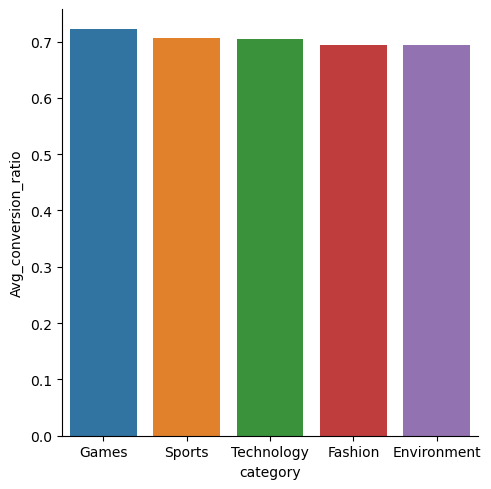

In [40]:
sns.catplot(data=View_Funding_by_Category[['category','Avg_conversion_ratio']],x='category',y='Avg_conversion_ratio',kind='bar')

2. Let's create a scatterplot of interval between actions (in hrs) v/s the average conversion rate by category

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


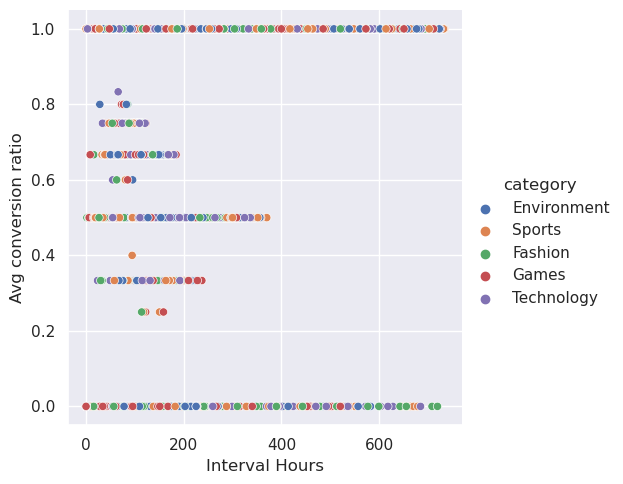

In [41]:
sns.set_theme(style='darkgrid')
plot_frame = final_cleaned_df.copy()
#Interval_by_Category = final_cleaned_df[['category','Fund Project','View Project','interval_between_actions','session_id']].groupby('session_id').agg({'Fund Project':'sum','View Project':'sum','interval_between_actions':'mean'}).reset_index()
plot_frame['Avg conversion ratio'] = plot_frame['Fund Project']/plot_frame['View Project']
plot_frame['Interval Hours'] = plot_frame['interval_between_actions']/3600
sns.relplot(data=plot_frame,x='Interval Hours',y='Avg conversion ratio',hue='category')

Hence no prominent correlation pattern can be drawn between the average conversion ratio and the interval between actions

2. Let's create a function that identify the average conversion rate by the columns that have been provided as inputs

In [42]:
def plot_correl(df,cols=['category','View Project','Fund Project']):
    agg_df = df[cols].groupby(cols).sum().reset_index()
    agg_df['Avg conversion ratio'] = agg_df['Fund Project']/agg_df['View Project']
    sns.catplot(data=agg_df,x=cols[0],y='Avg conversion ratio',hue=cols[1],kind='bar',errorbar=None)

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


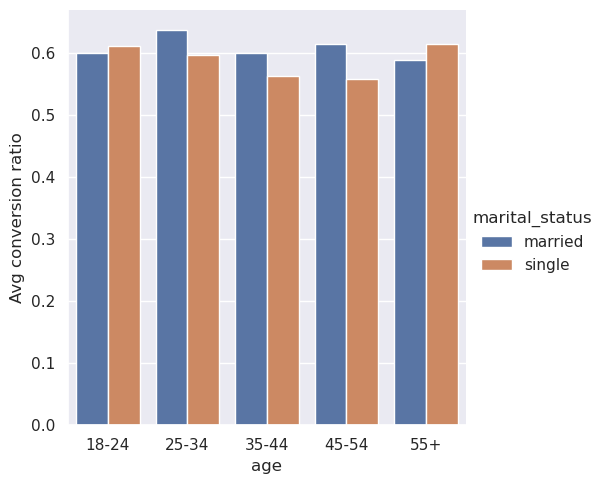

In [43]:
plot_correl(final_cleaned_df,['age','marital_status','View Project','Fund Project'])

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


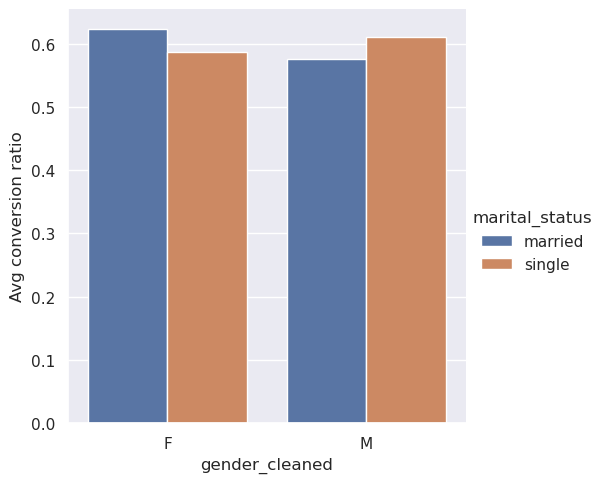

In [44]:
plot_correl(final_cleaned_df,['gender_cleaned','marital_status','View Project','Fund Project'])

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


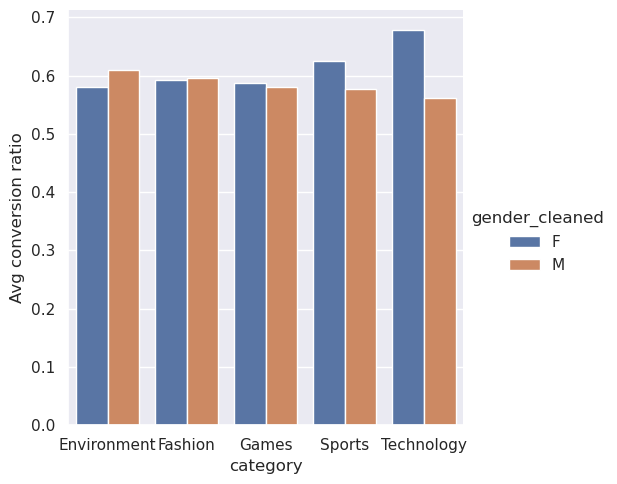

In [45]:
plot_correl(final_cleaned_df,['category','gender_cleaned','View Project','Fund Project'])

# User Segmentation and Identification of potential fund providers

To identify segments which are most likely to buy a particular input category, the approach would be to find the similarity between individuals based on the past funding preferences and use this similarity metric to identify individuals who are similar to the best fund provider for a category

Let's break down this approach into the following steps
1. Translate each data entry into an embedding vector
2. Set up a mechanism for determining cosine similarity between any two embedding vectors
3. With a category provided as input, find users similar to the top fund provider for the category
4. Visually represent the attributes of the selected similar users as segments

**Step 1: Translate each data entry into an embedding vector**

The approach that we will follow here is to represent the task as a regression problem with average conversion ratio as the dependent variable. The embedding matrix generated in the process of a training a tabular neural network on the problem can be used to translate the feature space into embedding vectors

1. Define the dependent variable and remove the features that can bias the result (Fund Project and View Project). Also we remove the session_id variable as it does not convey any demographic or behavioral attribute

In [46]:
df_nn = final_cleaned_df
df_nn['Avg_conversion_ratio'] = df_nn['Fund Project']/df_nn['View Project']
df_nn['interval_between_actions'] = df_nn['interval_between_actions']/3600
df_nn = df_nn.drop(['Fund Project','View Project','session_id','Views_per_funding'],axis='columns')

from fastai.tabular.all import *
dep_var = 'Avg_conversion_ratio'
cont_names,cat_names = cont_cat_split(df_nn, dep_var=dep_var)

In [47]:
cat_names

['category',
 'age',
 'marital_status',
 'device',
 'city',
 'state',
 'zip_code',
 'gender_cleaned']

2. Create a tabular dataloader with training and validation splits to train a regression model with multi-layer neural networks

In [48]:
tp_nn = TabularPandas(df_nn,y_names=dep_var,cont_names = cont_names, cat_names = cat_names,
                     procs=[Categorify,Normalize],splits=MaskSplitter([False]*df_nn.shape[0])
                     (range_of(df_nn))).dataloaders(bs=512,path='.')
tp_nn.show(5)

,category,age,marital_status,device,city,state,zip_code,gender_cleaned,interval_between_actions,latitude,longitude,Avg_conversion_ratio
0,Environment,35-44,single,iOS,El Paso,TX,79936,M,271.287628,31.711208,-106.243004,0.5
1,Sports,35-44,single,iOS,El Paso,TX,79936,M,0.000000,31.711208,-106.243004,0.0
2,Fashion,18-24,single,android,Atlanta,GA,30308,F,266.170563,33.794056,-84.377327,1.0
3,Games,18-24,single,android,Atlanta,GA,30308,F,107.685837,33.794056,-84.377327,1.0
4,Sports,18-24,single,android,Atlanta,GA,30308,F,42.081940,33.794056,-84.377327,1.0


3. Create a tabular neural network learner with 2 layers and train it on the taabular dataloader

In [49]:
learner = tabular_learner(tp_nn,layers=[512,256],y_range=(0,1.1),n_out=1,loss_func=F.mse_loss)

In [50]:
learner.fit_one_cycle(10,1e-2,wd=0.05)

epoch,train_loss,valid_loss,time
0,0.102128,None,00:01
1,0.085010,None,00:01
2,0.074077,None,00:01
3,0.062269,None,00:01
4,0.053838,None,00:01
5,0.046644,None,00:01
6,0.041484,None,00:01
7,0.035491,None,00:01
8,0.031140,None,00:01
9,0.027760,None,00:01


/opt/conda/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/opt/conda/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/opt/conda/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/opt/conda/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/opt/conda/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/opt/conda/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")
/opt/conda/lib/python3.10/site-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your 

3. Next we extract the embedding matrices created from the learner to generate embedding vectors corresponding to every data point

In [51]:
def get_embedding_vector(cat_names,df):
    for i,col in enumerate(cat_names):
        embed_matrix = to_np(next(learner.model.embeds[i].parameters()))
        col_embedding_vectors = pd.DataFrame(embed_matrix[df[col],:])
        col_embedding_vectors.rename(columns={j:col+'_'+str(j) for j in range(col_embedding_vectors.shape[1])},inplace=True)
        if i==0:
            result = col_embedding_vectors
        else:
            result = pd.concat([result,col_embedding_vectors],axis='columns')
    return result

In [52]:
embeddings = get_embedding_vector(cat_names,learner.dls.train.xs)
embeddings.head(10)

,category_0,category_1,category_2,category_3,age_0,age_1,age_2,age_3,marital_status_0,marital_status_1,...,zip_code_181,zip_code_182,zip_code_183,zip_code_184,zip_code_185,zip_code_186,zip_code_187,gender_cleaned_0,gender_cleaned_1,gender_cleaned_2
0,0.012817,0.027596,0.084053,-0.074107,-0.071587,0.008015,-0.010746,-0.071886,0.165562,0.124178,...,0.029090,-0.012666,0.012029,0.036718,0.006569,-0.003161,0.017962,0.187952,0.176097,-0.187451
1,0.027680,-0.010242,0.071025,-0.059684,-0.071587,0.008015,-0.010746,-0.071886,0.165562,0.124178,...,0.029090,-0.012666,0.012029,0.036718,0.006569,-0.003161,0.017962,0.187952,0.176097,-0.187451
2,0.019539,0.070217,0.047257,-0.073758,-0.081438,-0.010727,-0.004564,-0.021074,0.165562,0.124178,...,-0.037162,0.015446,0.009770,-0.015625,-0.019281,0.005401,0.006987,0.189236,0.166768,-0.197754
3,0.014068,-0.002378,0.098090,-0.063955,-0.081438,-0.010727,-0.004564,-0.021074,0.165562,0.124178,...,-0.037162,0.015446,0.009770,-0.015625,-0.019281,0.005401,0.006987,0.189236,0.166768,-0.197754
4,0.027680,-0.010242,0.071025,-0.059684,-0.081438,-0.010727,-0.004564,-0.021074,0.165562,0.124178,...,-0.037162,0.015446,0.009770,-0.015625,-0.019281,0.005401,0.006987,0.189236,0.166768,-0.197754
5,0.012817,0.027596,0.084053,-0.074107,-0.040065,-0.031018,0.010208,-0.042033,0.138996,0.156024,...,-0.032398,-0.010236,0.043114,-0.059667,-0.013670,0.027515,-0.080094,0.187952,0.176097,-0.187451
6,0.027680,-0.010242,0.071025,-0.059684,-0.040065,-0.031018,0.010208,-0.042033,0.138996,0.156024,...,-0.032398,-0.010236,0.043114,-0.059667,-0.013670,0.027515,-0.080094,0.187952,0.176097,-0.187451
7,0.012817,0.027596,0.084053,-0.074107,-0.040065,-0.031018,0.010208,-0.042033,0.138996,0.156024,...,0.027541,-0.064220,-0.043535,-0.053739,-0.043154,-0.038197,0.083307,0.189236,0.166768,-0.197754
8,0.019539,0.070217,0.047257,-0.073758,-0.040065,-0.031018,0.010208,-0.042033,0.138996,0.156024,...,0.027541,-0.064220,-0.043535,-0.053739,-0.043154,-0.038197,0.083307,0.189236,0.166768,-0.197754
9,0.014068,-0.002378,0.098090,-0.063955,-0.040065,-0.031018,0.010208,-0.042033,0.138996,0.156024,...,0.027541,-0.064220,-0.043535,-0.053739,-0.043154,-0.038197,0.083307,0.189236,0.166768,-0.197754


4. We combine these embeddings with the session_id (user identity) and the continuous columns

In [53]:
cont_columns_df = learner.dls.train.xs[cont_names] 
embedding_vect = pd.concat([embeddings,cont_columns_df,final_cleaned_df['session_id']],axis='columns')
embedding_vect.head(5)

,category_0,category_1,category_2,category_3,age_0,age_1,age_2,age_3,marital_status_0,marital_status_1,...,zip_code_185,zip_code_186,zip_code_187,gender_cleaned_0,gender_cleaned_1,gender_cleaned_2,interval_between_actions,latitude,longitude,session_id
0,0.012817,0.027596,0.084053,-0.074107,-0.071587,0.008015,-0.010746,-0.071886,0.165562,0.124178,...,0.006569,-0.003161,0.017962,0.187952,0.176097,-0.187451,0.953491,-1.417263,-0.711628,000716c0e76a41508feb786d202748e7
1,0.027680,-0.010242,0.071025,-0.059684,-0.071587,0.008015,-0.010746,-0.071886,0.165562,0.124178,...,0.006569,-0.003161,0.017962,0.187952,0.176097,-0.187451,-0.889975,-1.417263,-0.711628,000716c0e76a41508feb786d202748e7
2,0.019539,0.070217,0.047257,-0.073758,-0.081438,-0.010727,-0.004564,-0.021074,0.165562,0.124178,...,-0.019281,0.005401,0.006987,0.189236,0.166768,-0.197754,0.918719,-0.980256,0.643892,000e13dfa71146e192060542cda8721d
3,0.014068,-0.002378,0.098090,-0.063955,-0.081438,-0.010727,-0.004564,-0.021074,0.165562,0.124178,...,-0.019281,0.005401,0.006987,0.189236,0.166768,-0.197754,-0.158223,-0.980256,0.643892,000e13dfa71146e192060542cda8721d
4,0.027680,-0.010242,0.071025,-0.059684,-0.081438,-0.010727,-0.004564,-0.021074,0.165562,0.124178,...,-0.019281,0.005401,0.006987,0.189236,0.166768,-0.197754,-0.604018,-0.980256,0.643892,000e13dfa71146e192060542cda8721d


5. We drop the category related embedding columns to identify the unique embedding 

In [54]:
user_embedding = embedding_vect.drop([col for col in embedding_vect.columns if col.startswith('category')]+['interval_between_actions'],axis='columns')

In [55]:
user_embedding.shape

(22407, 358)

In [56]:
user_embedding.drop_duplicates(inplace=True,ignore_index=True)
user_embedding.shape

(10466, 358)

**Step 2: Set up a mechanism for determining cosine similarity between any two embedding vectors**

The Cosine Similarity function of torch can be used in this case to identify the distance of the best fund provider for a given category with the other fund providers

1. First we take a category as input and identify the best fund provider for that category. The best fund provider is then looked up in the embedding vector space of users and then evaluated for similary with the other users in the embedding space. The top 25%ile of similar users are then identified

In [57]:
import torch
def generate_similarity_score(input_category,percentile=0.25):
    #Identify the best fund provider for the input category
    idx = final_cleaned_df[final_cleaned_df.category==input_category].index
    best_funder_idx = idx[final_cleaned_df[final_cleaned_df.category==input_category]['Fund Project'].argmax(axis=0)]
    best_funder = final_cleaned_df.loc[best_funder_idx,'session_id']
    
    #Look up the embedding vector of the best funder and also prepare embedding vectors of other users
    best_funder_embedding_vect = user_embedding.loc[user_embedding['session_id']==best_funder]
    best_fund_tensor = torch.tensor(best_funder_embedding_vect.drop('session_id',axis='columns').values)
    user_embedding_tensor = torch.tensor(user_embedding.drop('session_id',axis='columns').values)
    
    #Compute cosine similarity scores and return top 25%ile of results
    cossim = torch.nn.CosineSimilarity(dim=1,eps=1e-6)
    similarity_scores = cossim(best_fund_tensor,user_embedding_tensor)
    top_similar_scores = torch.topk(similarity_scores,int(similarity_scores.shape[0]*percentile))
    
    return top_similar_scores

2. Construct a list of the most similar users based on the cosine similarity scores

In [63]:
def top_similar_users(input_category,percentile=0.25):
    top_similar_user_idx = generate_similarity_score(input_category,percentile).indices[1:]
    top_similar_users = user_embedding.loc[to_np(top_similar_user_idx),'session_id'].values
    top_similar_user_data = final_cleaned_df.loc[final_cleaned_df['session_id'].isin(top_similar_users)]
    return top_similar_user_data.drop(['Fund Project','View Project','Views_per_funding','Avg_conversion_ratio'],axis='columns')

In [71]:
potential_target_users = top_similar_users('Games',percentile=0.25)

From the returned results, it looks like latitude and longitude are dominant in determination of the similarity scores and hence users who stay in close proximity are treated as having higher extent of similarity

# Viusal representation of the Similar Users

Let's visualize the results on a street map of the shared locations

1. Remove the columns that turn redundant once data is displayed on a 2D-map view

In [78]:
viz_inputs = potential_target_users.drop(['session_id','category','interval_between_actions','state','zip_code'],axis='columns')
viz_inputs.shape

(5852, 7)

In [79]:
viz_inputs.drop_duplicates(inplace=True,ignore_index=True)
viz_inputs.shape

(985, 7)

In [80]:
viz_inputs.columns

Index(['age', 'marital_status', 'device', 'city', 'latitude', 'longitude',
       'gender_cleaned'],
      dtype='object')

In [65]:
import matplotlib.pyplot as plt

In [77]:
import plotly.graph_objects as go

In [89]:
device = viz_inputs['device'].copy()
device = device.astype('category')
device.cat.codes

0      0
1      1
2      0
3      1
4      0
      ..
980    0
981    0
982    0
983    0
984    1
Length: 985, dtype: int8

In [90]:
def show_users(display_var):
    cats = viz_inputs[display_var].astype('category')
    fig = go.Figure(data=go.Scattergeo(
        lon = viz_inputs['longitude'],
        lat = viz_inputs['latitude'],
        mode = 'markers',
        text = viz_inputs['city'],
        marker_color = cats.cat.codes
    ))
    
    fig.update_layout(
        title = 'Distribution of Target User Segments for BootLoader',
        geo_scope = 'usa'
    )
    return fig

In [93]:
figure = show_users('gender_cleaned')
figure.show()

## 